# Download Data


In [1]:
!wget https://raw.githubusercontent.com/iDataVisualizationLab/V/master/globalsoilspectral/data/ASD%20Spectra.csv
!wget https://raw.githubusercontent.com/iDataVisualizationLab/V/master/globalsoilspectral/data/Chemical_properties.csv
!wget https://raw.githubusercontent.com/iDataVisualizationLab/V/master/globalsoilspectral/data/ICRAF%20sample%20codes.csv

--2021-03-14 16:25:14--  https://raw.githubusercontent.com/iDataVisualizationLab/V/master/globalsoilspectral/data/ASD%20Spectra.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9414958 (9.0M) [text/plain]
Saving to: ‘ASD Spectra.csv.3’

ASD Spectra.csv.3   100%[===================>]   8.98M  --.-KB/s    in 0.07s   

2021-03-14 16:25:14 (135 MB/s) - ‘ASD Spectra.csv.3’ saved [9414958/9414958]

--2021-03-14 16:25:14--  https://raw.githubusercontent.com/iDataVisualizationLab/V/master/globalsoilspectral/data/Chemical_properties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP r

In [2]:
pip install shap

# Assure reproducibility


In [3]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

# Basic Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Load related tables
asdspectra = pd.read_csv('ASD Spectra.csv')
chemicalproperties = pd.read_csv('Chemical_properties.csv')
sample_codes = pd.read_csv('ICRAF sample codes.csv')

# Join tables

In [6]:
# Join between sample code and asdspectra
asdspectra_sample_info = pd.merge(sample_codes, asdspectra, left_on='Batch and labid', right_on='Batch_Labid')
data = pd.merge(chemicalproperties, asdspectra_sample_info, left_on=['SAMPLENO', 'HORI', 'BTOP', 'BBOT'], right_on = ['Sampleno', 'HORI', 'BTOP', 'BBOT'])

In [7]:
# Drop columns with too many missing data
cols_to_drop = ['CASO4', 'PHCACL2', 'C/N', 'ESP', 'CHEMREM', 'VERIFIED', 'CACO3', 'ALS', 'EXACID', 'EXAL', 'ORGN', 'EDITDATE', 'ISO']
data.drop(cols_to_drop, inplace=True, axis=1)
# drop also properties that we do not care by now
cols_to_drop = ['ORGC', 'CA', 'MG', 'NA', 'K', 'SUM', 'CECSOIL', 'CECCLAY', 'CECORG', 'ECEC', 'BS', 'EC']
data.drop(cols_to_drop, inplace=True, axis=1)

In [8]:
# View NaN information
data.isna().sum().sort_values(axis=0, ascending=False)[:5]

PHKCL    348
PHH2O    302
W2500      0
W930       0
W1050      0
dtype: int64

In [9]:
# Drop rows with NaN
data.dropna(inplace=True)
data

,ID,HORI,BTOP,BBOT,SAMPLENO,PHH2O,PHKCL,Batch and labid,Sampleno,Country name,Plotcode,Dsed,Batch_Labid,W350,W360,W370,W380,W390,W400,W410,W420,W430,W440,W450,W460,W470,W480,W490,W500,W510,W520,W530,W540,W550,W560,W570,W580,W590,W600,W610,...,W2110,W2120,W2130,W2140,W2150,W2160,W2170,W2180,W2190,W2200,W2210,W2220,W2230,W2240,W2250,W2260,W2270,W2280,W2290,W2300,W2310,W2320,W2330,W2340,W2350,W2360,W2370,W2380,W2390,W2400,W2410,W2420,W2430,W2440,W2450,W2460,W2470,W2480,W2490,W2500
0,3,2,9.0,36.0,850173,4.9,4.2,FS15R_FS4084,850173,Brazil,BR 3,8.556,FS15R_FS4084,0.063873,0.053166,0.052075,0.053676,0.054828,0.055085,0.055827,0.058160,0.063685,0.069349,0.073487,0.074060,0.073832,0.076162,0.081424,0.089063,0.097476,0.106159,0.116864,0.130292,0.146955,0.166677,0.188231,0.209849,0.227339,0.241298,0.251166,...,0.402475,0.401561,0.398616,0.386035,0.359827,0.337861,0.331165,0.327764,0.317506,0.294888,0.286396,0.333530,0.344781,0.339681,0.335606,0.330757,0.325323,0.326507,0.325564,0.322197,0.315582,0.313351,0.314001,0.312835,0.304573,0.299685,0.297523,0.289738,0.289660,0.294314,0.293681,0.289459,0.281451,0.272767,0.268650,0.265930,0.267394,0.263076,0.265060,0.263892
1,3,3,36.0,72.0,850174,4.8,4.3,FS15R_FS4085,850174,Brazil,BR 3,9.529,FS15R_FS4085,0.061739,0.050505,0.047442,0.047695,0.049629,0.050175,0.050638,0.053184,0.057982,0.063486,0.067347,0.067757,0.067096,0.069332,0.074375,0.081452,0.089294,0.097902,0.108513,0.122208,0.139496,0.160591,0.184594,0.209171,0.229607,0.246075,0.257449,...,0.395380,0.394319,0.390849,0.377368,0.350428,0.327799,0.320736,0.316989,0.307033,0.283482,0.275759,0.323539,0.335316,0.330339,0.326425,0.321987,0.316931,0.318593,0.317470,0.313661,0.307281,0.304690,0.305239,0.303586,0.295048,0.290328,0.287393,0.279556,0.280107,0.284282,0.283301,0.279047,0.271887,0.263713,0.258356,0.257120,0.256613,0.255632,0.264612,0.259878
2,3,4,72.0,102.0,850175,5.0,4.5,FS15R_FS4086,850175,Brazil,BR 3,9.766,FS15R_FS4086,0.064619,0.051373,0.047279,0.049530,0.051286,0.050792,0.052239,0.053508,0.057438,0.062418,0.065711,0.066037,0.065985,0.067653,0.072045,0.078483,0.085733,0.093851,0.103607,0.116567,0.133447,0.154204,0.178067,0.203068,0.224170,0.241576,0.253738,...,0.404309,0.403139,0.399220,0.384769,0.355382,0.331486,0.324341,0.320555,0.310045,0.285143,0.276554,0.328177,0.340833,0.336130,0.332253,0.327559,0.322436,0.323801,0.322715,0.318385,0.311635,0.307952,0.309254,0.307658,0.299511,0.294121,0.289911,0.281979,0.283191,0.286861,0.287574,0.282995,0.273608,0.264221,0.261296,0.259307,0.257153,0.258605,0.257526,0.260196
3,3,5,102.0,147.0,850176,5.7,5.0,FS15R_FS4087,850176,Brazil,BR 3,13.108,FS15R_FS4087,0.081510,0.059976,0.054854,0.056135,0.056486,0.058501,0.059897,0.062874,0.067484,0.075341,0.079278,0.079385,0.078678,0.080630,0.086648,0.096212,0.106992,0.118720,0.133123,0.151293,0.173793,0.200207,0.228806,0.257321,0.280093,0.297413,0.308308,...,0.429698,0.428658,0.424564,0.409494,0.379295,0.353509,0.346199,0.342765,0.331441,0.305407,0.295575,0.349523,0.362702,0.356629,0.352220,0.346513,0.340428,0.343135,0.342505,0.338375,0.331429,0.327744,0.328939,0.327481,0.318122,0.312346,0.308926,0.301123,0.302021,0.305642,0.307594,0.301443,0.294271,0.284187,0.277458,0.278195,0.273965,0.268860,0.278085,0.280141
4,4,1,0.0,18.0,850178,6.4,5.4,FS15R_FS4089,850178,Brazil,BR 4,1.498,FS15R_FS4089,0.032692,0.026642,0.023296,0.024360,0.023163,0.024975,0.023672,0.023350,0.024681,0.025619,0.026069,0.027006,0.028130,0.028590,0.029748,0.031033,0.032440,0.033991,0.036113,0.039502,0.044398,0.051416,0.060660,0.071292,0.081543,0.091135,0.098933,...,0.156165,0.156807,0.157615,0.157210,0.155323,0.153112,0.151230,0.149947,0.148435,0.146489,0.146181,0.149814,0.150410,0.149328,0.147810,0.146645,0.146287,0.148273,0.149533,0.149687,0.150016,0.149991,0.151016,0.151287,0.151587,0.150618,0.150914,0.150359,0.150514,0.152079,0.153008,0.151589,0.151984,0.150393,0.149423,0.149009,0.142426,0.147978,0.142024,0.145657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [10]:
# See unique samples
len(data['SAMPLENO'].unique())

3838

We can observe the difference in number of samples and number of rows. So there is a duplication, we will delete the first row (assuming the second row is the latest information).

In [11]:
s = data.groupby('SAMPLENO')['SAMPLENO'].count().loc[data.groupby('SAMPLENO')['SAMPLENO'].count()>1]

In [12]:
s

SAMPLENO
000057    2
660023    2
680022    2
700032    2
710006    2
710007    2
710008    2
710009    2
710010    2
710057    2
710068    2
710069    2
710070    2
710071    2
710073    2
710074    2
710075    2
710076    2
710077    2
710078    2
710079    2
710080    2
710131    2
710132    2
710133    2
730184    2
740053    2
770089    2
830396    2
840256    2
850371    2
860212    2
860215    2
860218    2
860221    2
860223    2
860230    2
870447    2
880045    2
920424    2
931250    2
931251    2
931252    2
Name: SAMPLENO, dtype: int64

In [13]:
# Will keep the second one (delete the smaller index)
for idx in list(s.index):
    data.drop(data[data['SAMPLENO'] == idx].index.min(), inplace=True, axis=0)

In [14]:
data

,ID,HORI,BTOP,BBOT,SAMPLENO,PHH2O,PHKCL,Batch and labid,Sampleno,Country name,Plotcode,Dsed,Batch_Labid,W350,W360,W370,W380,W390,W400,W410,W420,W430,W440,W450,W460,W470,W480,W490,W500,W510,W520,W530,W540,W550,W560,W570,W580,W590,W600,W610,...,W2110,W2120,W2130,W2140,W2150,W2160,W2170,W2180,W2190,W2200,W2210,W2220,W2230,W2240,W2250,W2260,W2270,W2280,W2290,W2300,W2310,W2320,W2330,W2340,W2350,W2360,W2370,W2380,W2390,W2400,W2410,W2420,W2430,W2440,W2450,W2460,W2470,W2480,W2490,W2500
0,3,2,9.0,36.0,850173,4.9,4.2,FS15R_FS4084,850173,Brazil,BR 3,8.556,FS15R_FS4084,0.063873,0.053166,0.052075,0.053676,0.054828,0.055085,0.055827,0.058160,0.063685,0.069349,0.073487,0.074060,0.073832,0.076162,0.081424,0.089063,0.097476,0.106159,0.116864,0.130292,0.146955,0.166677,0.188231,0.209849,0.227339,0.241298,0.251166,...,0.402475,0.401561,0.398616,0.386035,0.359827,0.337861,0.331165,0.327764,0.317506,0.294888,0.286396,0.333530,0.344781,0.339681,0.335606,0.330757,0.325323,0.326507,0.325564,0.322197,0.315582,0.313351,0.314001,0.312835,0.304573,0.299685,0.297523,0.289738,0.289660,0.294314,0.293681,0.289459,0.281451,0.272767,0.268650,0.265930,0.267394,0.263076,0.265060,0.263892
1,3,3,36.0,72.0,850174,4.8,4.3,FS15R_FS4085,850174,Brazil,BR 3,9.529,FS15R_FS4085,0.061739,0.050505,0.047442,0.047695,0.049629,0.050175,0.050638,0.053184,0.057982,0.063486,0.067347,0.067757,0.067096,0.069332,0.074375,0.081452,0.089294,0.097902,0.108513,0.122208,0.139496,0.160591,0.184594,0.209171,0.229607,0.246075,0.257449,...,0.395380,0.394319,0.390849,0.377368,0.350428,0.327799,0.320736,0.316989,0.307033,0.283482,0.275759,0.323539,0.335316,0.330339,0.326425,0.321987,0.316931,0.318593,0.317470,0.313661,0.307281,0.304690,0.305239,0.303586,0.295048,0.290328,0.287393,0.279556,0.280107,0.284282,0.283301,0.279047,0.271887,0.263713,0.258356,0.257120,0.256613,0.255632,0.264612,0.259878
2,3,4,72.0,102.0,850175,5.0,4.5,FS15R_FS4086,850175,Brazil,BR 3,9.766,FS15R_FS4086,0.064619,0.051373,0.047279,0.049530,0.051286,0.050792,0.052239,0.053508,0.057438,0.062418,0.065711,0.066037,0.065985,0.067653,0.072045,0.078483,0.085733,0.093851,0.103607,0.116567,0.133447,0.154204,0.178067,0.203068,0.224170,0.241576,0.253738,...,0.404309,0.403139,0.399220,0.384769,0.355382,0.331486,0.324341,0.320555,0.310045,0.285143,0.276554,0.328177,0.340833,0.336130,0.332253,0.327559,0.322436,0.323801,0.322715,0.318385,0.311635,0.307952,0.309254,0.307658,0.299511,0.294121,0.289911,0.281979,0.283191,0.286861,0.287574,0.282995,0.273608,0.264221,0.261296,0.259307,0.257153,0.258605,0.257526,0.260196
3,3,5,102.0,147.0,850176,5.7,5.0,FS15R_FS4087,850176,Brazil,BR 3,13.108,FS15R_FS4087,0.081510,0.059976,0.054854,0.056135,0.056486,0.058501,0.059897,0.062874,0.067484,0.075341,0.079278,0.079385,0.078678,0.080630,0.086648,0.096212,0.106992,0.118720,0.133123,0.151293,0.173793,0.200207,0.228806,0.257321,0.280093,0.297413,0.308308,...,0.429698,0.428658,0.424564,0.409494,0.379295,0.353509,0.346199,0.342765,0.331441,0.305407,0.295575,0.349523,0.362702,0.356629,0.352220,0.346513,0.340428,0.343135,0.342505,0.338375,0.331429,0.327744,0.328939,0.327481,0.318122,0.312346,0.308926,0.301123,0.302021,0.305642,0.307594,0.301443,0.294271,0.284187,0.277458,0.278195,0.273965,0.268860,0.278085,0.280141
4,4,1,0.0,18.0,850178,6.4,5.4,FS15R_FS4089,850178,Brazil,BR 4,1.498,FS15R_FS4089,0.032692,0.026642,0.023296,0.024360,0.023163,0.024975,0.023672,0.023350,0.024681,0.025619,0.026069,0.027006,0.028130,0.028590,0.029748,0.031033,0.032440,0.033991,0.036113,0.039502,0.044398,0.051416,0.060660,0.071292,0.081543,0.091135,0.098933,...,0.156165,0.156807,0.157615,0.157210,0.155323,0.153112,0.151230,0.149947,0.148435,0.146489,0.146181,0.149814,0.150410,0.149328,0.147810,0.146645,0.146287,0.148273,0.149533,0.149687,0.150016,0.149991,0.151016,0.151287,0.151587,0.150618,0.150914,0.150359,0.150514,0.152079,0.153008,0.151589,0.151984,0.150393,0.149423,0.149009,0.142426,0.147978,0.142024,0.145657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Focusing on PHH2O and PHKCL by now

In [15]:
# Select the two variables
variables = ['PHH2O', 'PHKCL']
# Consider these wavebands
wavelengths = [wl for wl in range(350, 2500+1, 10)]
wavebands = ['W'+str(wl) for wl in wavelengths]
# Select data
df = data[variables + wavebands]
df.reset_index(drop=True, inplace=True)

# Now we have cleaned data

In [16]:
df

,PHH2O,PHKCL,W350,W360,W370,W380,W390,W400,W410,W420,W430,W440,W450,W460,W470,W480,W490,W500,W510,W520,W530,W540,W550,W560,W570,W580,W590,W600,W610,W620,W630,W640,W650,W660,W670,W680,W690,W700,W710,W720,...,W2110,W2120,W2130,W2140,W2150,W2160,W2170,W2180,W2190,W2200,W2210,W2220,W2230,W2240,W2250,W2260,W2270,W2280,W2290,W2300,W2310,W2320,W2330,W2340,W2350,W2360,W2370,W2380,W2390,W2400,W2410,W2420,W2430,W2440,W2450,W2460,W2470,W2480,W2490,W2500
0,4.9,4.2,0.063873,0.053166,0.052075,0.053676,0.054828,0.055085,0.055827,0.058160,0.063685,0.069349,0.073487,0.074060,0.073832,0.076162,0.081424,0.089063,0.097476,0.106159,0.116864,0.130292,0.146955,0.166677,0.188231,0.209849,0.227339,0.241298,0.251166,0.258279,0.264097,0.269541,0.274754,0.279945,0.285722,0.292045,0.299254,0.307030,0.315087,0.323271,...,0.402475,0.401561,0.398616,0.386035,0.359827,0.337861,0.331165,0.327764,0.317506,0.294888,0.286396,0.333530,0.344781,0.339681,0.335606,0.330757,0.325323,0.326507,0.325564,0.322197,0.315582,0.313351,0.314001,0.312835,0.304573,0.299685,0.297523,0.289738,0.289660,0.294314,0.293681,0.289459,0.281451,0.272767,0.268650,0.265930,0.267394,0.263076,0.265060,0.263892
1,4.8,4.3,0.061739,0.050505,0.047442,0.047695,0.049629,0.050175,0.050638,0.053184,0.057982,0.063486,0.067347,0.067757,0.067096,0.069332,0.074375,0.081452,0.089294,0.097902,0.108513,0.122208,0.139496,0.160591,0.184594,0.209171,0.229607,0.246075,0.257449,0.265132,0.270984,0.276185,0.280996,0.285824,0.291677,0.298214,0.305690,0.314004,0.322705,0.331586,...,0.395380,0.394319,0.390849,0.377368,0.350428,0.327799,0.320736,0.316989,0.307033,0.283482,0.275759,0.323539,0.335316,0.330339,0.326425,0.321987,0.316931,0.318593,0.317470,0.313661,0.307281,0.304690,0.305239,0.303586,0.295048,0.290328,0.287393,0.279556,0.280107,0.284282,0.283301,0.279047,0.271887,0.263713,0.258356,0.257120,0.256613,0.255632,0.264612,0.259878
2,5.0,4.5,0.064619,0.051373,0.047279,0.049530,0.051286,0.050792,0.052239,0.053508,0.057438,0.062418,0.065711,0.066037,0.065985,0.067653,0.072045,0.078483,0.085733,0.093851,0.103607,0.116567,0.133447,0.154204,0.178067,0.203068,0.224170,0.241576,0.253738,0.262255,0.268623,0.274179,0.279199,0.284449,0.290592,0.297476,0.305460,0.314136,0.323268,0.332520,...,0.404309,0.403139,0.399220,0.384769,0.355382,0.331486,0.324341,0.320555,0.310045,0.285143,0.276554,0.328177,0.340833,0.336130,0.332253,0.327559,0.322436,0.323801,0.322715,0.318385,0.311635,0.307952,0.309254,0.307658,0.299511,0.294121,0.289911,0.281979,0.283191,0.286861,0.287574,0.282995,0.273608,0.264221,0.261296,0.259307,0.257153,0.258605,0.257526,0.260196
3,5.7,5.0,0.081510,0.059976,0.054854,0.056135,0.056486,0.058501,0.059897,0.062874,0.067484,0.075341,0.079278,0.079385,0.078678,0.080630,0.086648,0.096212,0.106992,0.118720,0.133123,0.151293,0.173793,0.200207,0.228806,0.257321,0.280093,0.297413,0.308308,0.314543,0.318690,0.321861,0.325162,0.329005,0.334108,0.340247,0.347803,0.356351,0.365718,0.375503,...,0.429698,0.428658,0.424564,0.409494,0.379295,0.353509,0.346199,0.342765,0.331441,0.305407,0.295575,0.349523,0.362702,0.356629,0.352220,0.346513,0.340428,0.343135,0.342505,0.338375,0.331429,0.327744,0.328939,0.327481,0.318122,0.312346,0.308926,0.301123,0.302021,0.305642,0.307594,0.301443,0.294271,0.284187,0.277458,0.278195,0.273965,0.268860,0.278085,0.280141
4,6.4,5.4,0.032692,0.026642,0.023296,0.024360,0.023163,0.024975,0.023672,0.023350,0.024681,0.025619,0.026069,0.027006,0.028130,0.028590,0.029748,0.031033,0.032440,0.033991,0.036113,0.039502,0.044398,0.051416,0.060660,0.071292,0.081543,0.091135,0.098933,0.105374,0.110655,0.115005,0.119010,0.123011,0.127305,0.131583,0.135827,0.139818,0.143360,0.146519,...,0.156165,0.156807,0.157615,0.157210,0.155323,0.153112,0.151230,0.149947,0.148435,0.146489,0.146181,0.149814,0.150410,0.149328,0.147810,0.146645,0.146287,0.148273,0.149533,0.149687,0.150016,0.149991,0.151016,0.151287,0.151587,0.150618,0.150914,0.150359,0.150514,0.152079,0.153008,0.151589,0.151984,0.150393,0.149423,0.149009,0.142426,

In [17]:
df[variables].describe()

,PHH2O,PHKCL
count,3838.000000,3838.000000
mean,6.140334,5.186269
std,1.423334,1.324753
min,3.000000,2.400000
25%,5.000000,4.100000
50%,5.900000,4.800000
75%,7.200000,6.100000
max,10.500000,9.800000


In [18]:
X = df[wavebands].values
y = df[variables].values

# Convert data using Savitzky Golay

In [19]:
from scipy.signal import savgol_filter

In [20]:
X = savgol_filter(X, window_length = 11, polyorder=5, deriv=1)

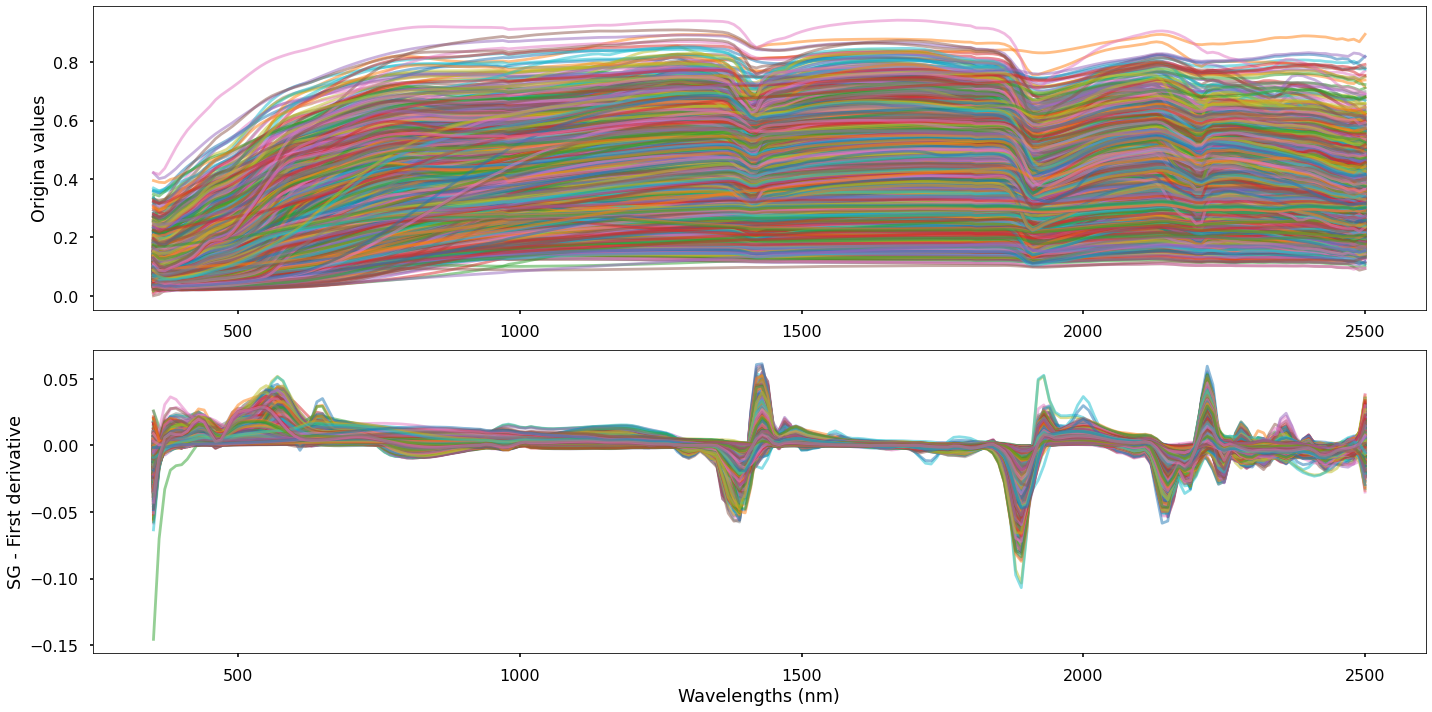

In [21]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(211)
    ax1.plot(wavelengths, df[wavebands].values.T, alpha=0.5)
#     ax1.set_xlabel("Wavelengths (nm)")
    ax1.set_ylabel("Origina values")
    
    ax2 = plt.subplot(212, sharex=ax1)
    ax2.plot(wavelengths, X.T, alpha=0.5)
    ax2.set_xlabel("Wavelengths (nm)")
    ax2.set_ylabel("SG - First derivative")

    plt.tight_layout()
    plt.plot()

# Splitting data into train/valid/test sets

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1/9, random_state=42)
print(len(X_train), len(X_valid), len(X_test))

3070 384 384


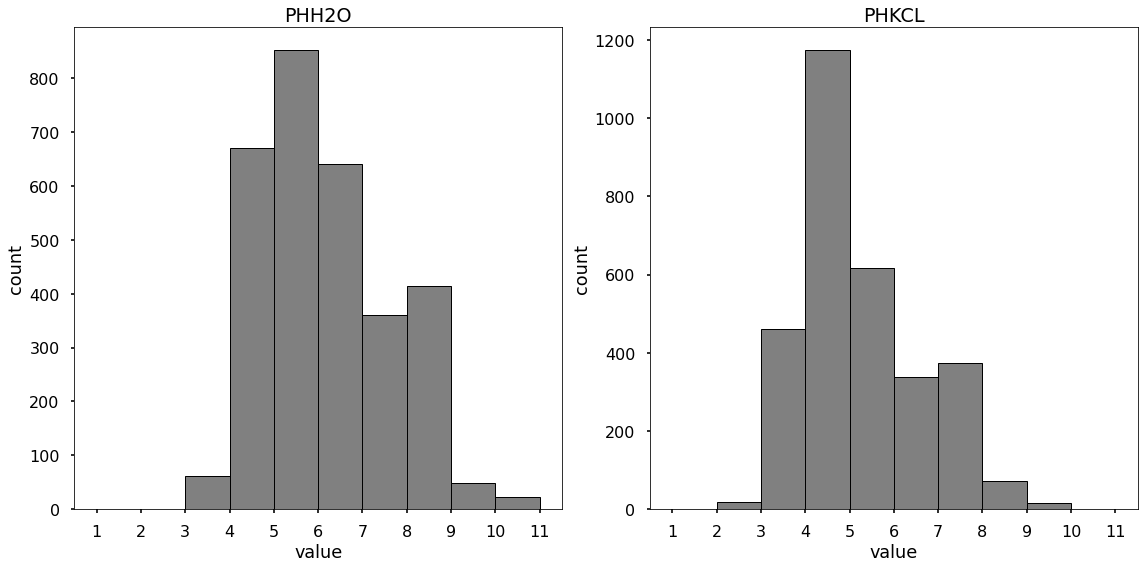

In [24]:
# Plot the outputs and see how they are
ncols=2
with plt.style.context('seaborn-poster'):
    fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(16, 8))
    for ncol in range(ncols):
        idx = ncol
        if idx < len(variables):
            axes[ncol].hist(y_train[:, idx], bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], color = "gray", lw=1, ec='black')
            axes[ncol].set_title(variables[idx])
            axes[ncol].set_xlabel('value')
            axes[ncol].set_ylabel('count')
            axes[ncol].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    plt.tight_layout()
    plt.plot()

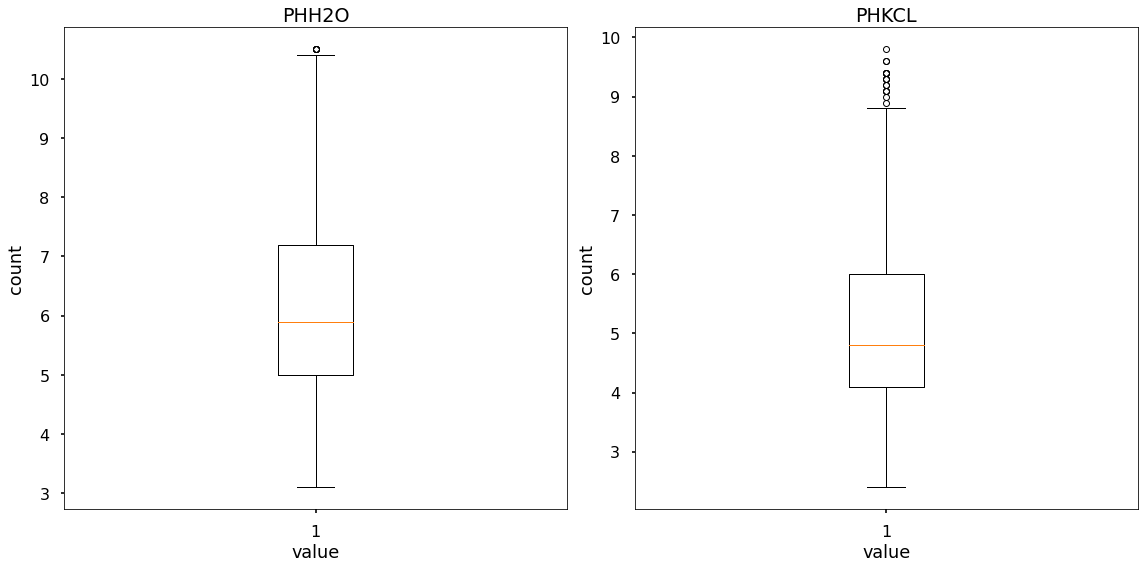

In [25]:
ncols=2
with plt.style.context('seaborn-poster'):
    fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(16, 8))
    for ncol in range(ncols):
        idx = ncol
        if idx < len(variables):
            axes[ncol].boxplot(y_train[:, idx])
            axes[ncol].set_title(variables[idx])
            axes[ncol].set_xlabel('value')
            axes[ncol].set_ylabel('count')
    plt.tight_layout()
    plt.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


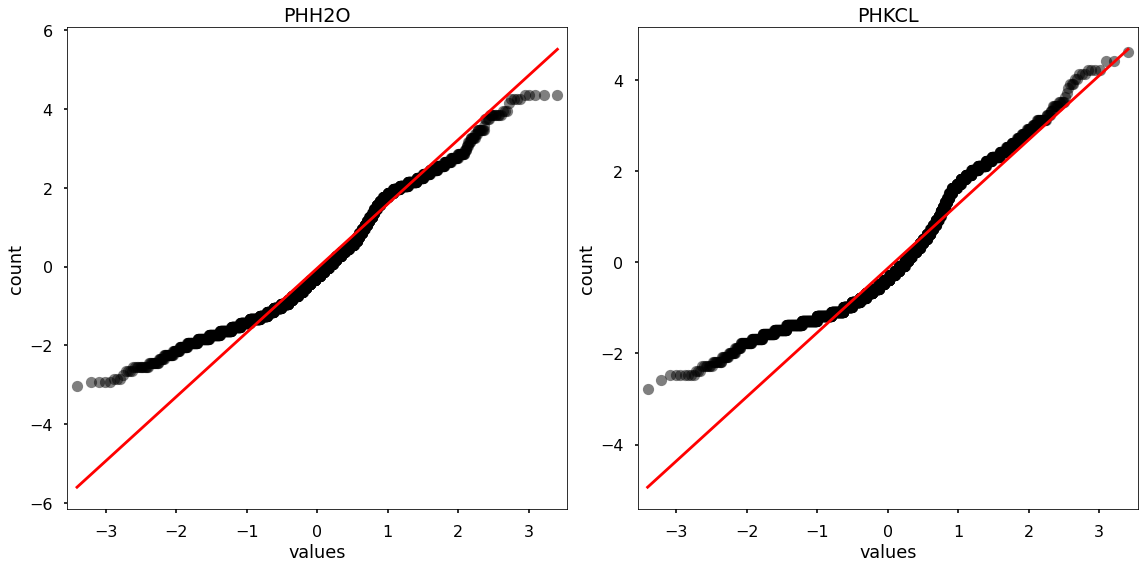

In [26]:
import statsmodels.api as sm
# Plot the outputs and see how they are
ncols=2
with plt.style.context('seaborn-poster'):
    fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(16, 8))
    for ncol in range(ncols):
        idx = ncol
        if idx < len(variables):
            sm.qqplot(y_train[:, idx] - np.mean(y_train[:, idx]), line='q', ax=axes[ncol], alpha=0.5)
            # Grab the lines with blue dots
            dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
            [d.set_markerfacecolor('k') for d in dots]            
            axes[ncol].set_title(variables[idx])
            axes[ncol].set_xlabel('values')
            axes[ncol].set_ylabel('count')
    plt.tight_layout()
    plt.plot()

# Define evaluation metrics

In [27]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
def evaluate(y_true, y_pred):
    mse = np.array([mean_squared_error(y_true[:, idx], y_pred[:,idx]) for idx in range(len(y_true[0]))])
    r2 = np.array([r2_score(y_true[: ,idx], y_pred[:, idx]) for idx in range(len(y_true[0]))])
    rpd = y_true.std()/np.sqrt(mse)
    return mse, r2, rpd

def evaluate_model(model, X, y):
    pred = model.predict(X)
    if(tf.is_tensor(pred)):
        pred = pred.numpy()
        
    return pred, evaluate(y.squeeze(), pred.squeeze())

In [29]:
def evaluate_and_plot(X, y, model):
    y_pred, (mse, r2, rpd) = evaluate_model(model, X, y)
    with plt.style.context('seaborn-poster'):
        fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(16, 8))
        for var_idx in range(len(variables)):
            title = f'{variables[var_idx]}, MSE: {np.round(mse[var_idx], 2)}, R2: {np.round(r2[var_idx], 2)}, RPD: {np.round(rpd[var_idx], 2)}'
            # Print the result
            print('MSE: %0.4f' % (mse[var_idx]))
            print('R2: %0.4f' % (r2[var_idx]))
            print('RPD: %0.4f' % (rpd[var_idx]))
            # plot the regression
            p = np.polyfit(y[:, var_idx], y_pred[:, var_idx], deg=1)
            axes[var_idx].scatter(y[:, var_idx], y_pred[:, var_idx], color='gray', edgecolors='black', alpha=0.5)
            axes[var_idx].plot(y[:, var_idx], y[:, var_idx], '-k', label='Expectation')
            axes[var_idx].plot(y[:, var_idx], np.polyval(p, y[:, var_idx]),'-.k', label='Prediction regression')
            axes[var_idx].legend()
            axes[var_idx].set_xlabel('Actual')
            axes[var_idx].set_ylabel('Predicted')
            axes[var_idx].set_title(title)
        plt.plot()
    return y_pred, mse, r2, rpd

# MLP Exploration

# Feedforward network

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, input_shape=(216,), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2)
])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=16, epochs=1000, callbacks=[es])
model.save('mlp.h5')

Epoch 1/1000
192/192 [==============================] - 4s 5ms/step - loss: 11.2468 - val_loss: 1.6791
Epoch 2/1000
192/192 [==============================] - 1s 3ms/step - loss: 1.7605 - val_loss: 1.3449
Epoch 3/1000
192/192 [==============================] - 1s 3ms/step - loss: 1.6043 - val_loss: 1.0071
Epoch 4/1000
192/192 [==============================] - 1s 3ms/step - loss: 1.4696 - val_loss: 1.2961
Epoch 5/1000
192/192 [==============================] - 0s 3ms/step - loss: 1.3372 - val_loss: 1.0072
Epoch 6/1000
192/192 [==============================] - 1s 3ms/step - loss: 1.3724 - val_loss: 0.8777
Epoch 7/1000
192/192 [==============================] - 0s 3ms/step - loss: 1.2058 - val_loss: 0.8427
Epoch 8/1000
192/192 [==============================] - 1s 3ms/step - loss: 1.2602 - val_loss: 0.8997
Epoch 9/1000
192/192 [==============================] - 1s 3ms/step - loss: 1.0928 - val_loss: 1.0315
Epoch 10/1000
192/192 [==============================] - 0s 3ms/step - loss: 1.08

(0.2, 1.0)

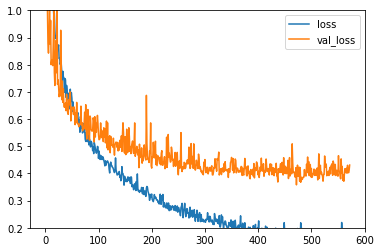

In [31]:
train_df = pd.DataFrame(history.history)
train_df.plot()
plt.ylim([0.2,1.0])

MSE: 0.3718
R2: 0.8210
RPD: 2.4155
MSE: 0.3443
R2: 0.8110
RPD: 2.5102


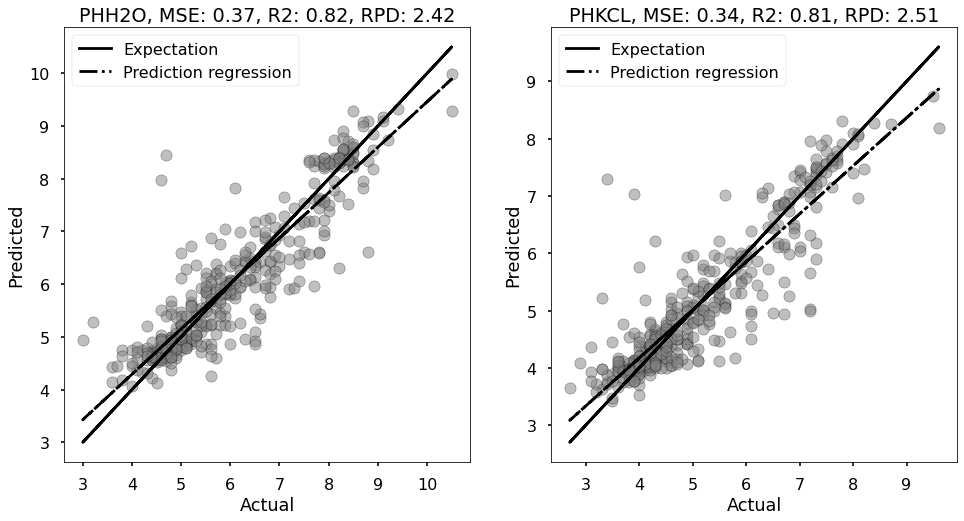

In [32]:
_ = evaluate_and_plot(X_valid, y_valid, model)

# Feature importance

In [33]:
import shap
def get_shap_values(X_test, model, num_rows=None):
    model1 = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.layers[-1].output[:, 0]])
    model2 = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.layers[-1].output[:, 1]])
    kernel_explainer1 = shap.KernelExplainer(model1.predict,X_test)
    kernel_explainer2 = shap.KernelExplainer(model2.predict,X_test)
    kernel_shap_values1 = np.abs(kernel_explainer1.shap_values(X_test[:num_rows]))
    kernel_shap_values2 = np.abs(kernel_explainer2.shap_values(X_test[:num_rows]))
    kernel_shap_values = np.concatenate([kernel_shap_values1, kernel_shap_values2], axis=0)
    return np.mean(kernel_shap_values, axis=0)

In [34]:
def plot_spectra_vs_model_feature_importance(X, wl, features):
    # Plot spectra
    plt.figure(figsize=(16, 8))
    with plt.style.context('seaborn-poster'):
        ax1 = plt.subplot(211)
        plt.plot(wl, X.T)
        plt.ylabel("SG - Values")

        ax2 = plt.subplot(212, sharex=ax1)
        plt.scatter(wl, features, color='gray', edgecolors='black', alpha=0.5)
        

        plt.xlabel("Wavelength (nm)")
        plt.ylabel("feature importances")

        plt.show()

In [35]:
# TODO: Change num_rows = None to evaluate on all rows
num_rows = 2 # 31 is sufficient for statistical calculation

Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


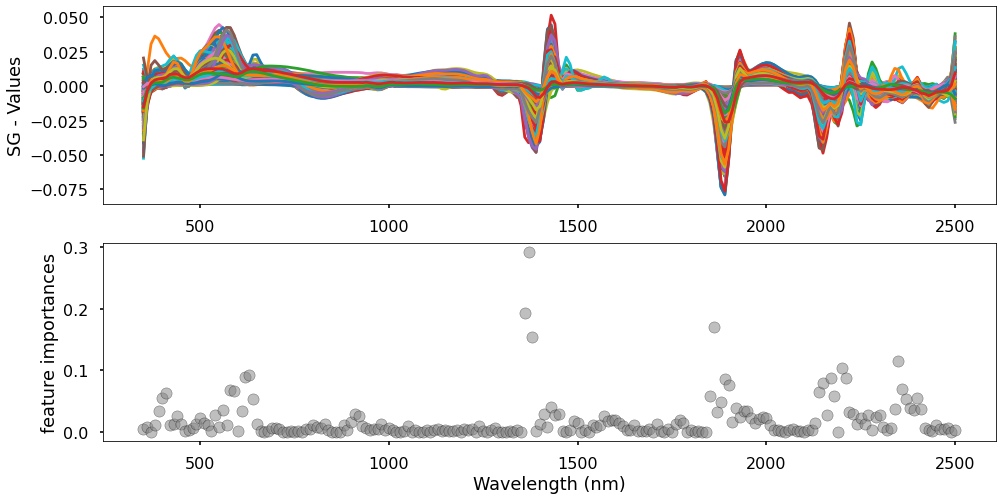

In [36]:
svs = get_shap_values(X_test, model, num_rows)
plot_spectra_vs_model_feature_importance(X_test, wavelengths, svs)

# LSTM or Bidirectional LSTM do not work for this very long sequence

In [37]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(32, input_shape=(216,1), activation='elu', return_sequences=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(512, activation='elu'),
#     tf.keras.layers.Dense(256, activation='elu'),
#     tf.keras.layers.Dense(128, activation='elu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(2)
# ])
# model.compile(optimizer='adam', loss='mse')
# history = model.fit(np.expand_dims(X_train, 2), y_train, validation_data=(np.expand_dims(X_valid, 2), y_valid), batch_size=32, epochs=150)
# train_df = pd.DataFrame(history.history)
# train_df.plot()

# CNN

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(target_shape=[216, 1], input_shape=(216,)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1000, batch_size=32, callbacks=[es])
# model.save('cnn.h5')

Epoch 1/1000
96/96 [==============================] - 14s 14ms/step - loss: 12.1270 - val_loss: 2.0610
Epoch 2/1000
96/96 [==============================] - 1s 5ms/step - loss: 2.0326 - val_loss: 2.2683
Epoch 3/1000
96/96 [==============================] - 1s 5ms/step - loss: 2.1776 - val_loss: 2.1020
Epoch 4/1000
96/96 [==============================] - 1s 5ms/step - loss: 2.0873 - val_loss: 1.9598
Epoch 5/1000
96/96 [==============================] - 1s 5ms/step - loss: 2.0792 - val_loss: 1.9345
Epoch 6/1000
96/96 [==============================] - 1s 5ms/step - loss: 2.0028 - val_loss: 1.9243
Epoch 7/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.9470 - val_loss: 1.8522
Epoch 8/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.9093 - val_loss: 1.6317
Epoch 9/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.8869 - val_loss: 1.5596
Epoch 10/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.5988 - val_loss: 1.4

In [39]:
def evaluation():
    train_df = pd.DataFrame(history.history)
    train_df.plot()
    plt.ylim([0.2,1.0])

    _ = evaluate_and_plot(X_valid, y_valid, model)

    svs = get_shap_values(X_test, model, num_rows)
    plot_spectra_vs_model_feature_importance(X_test, wavelengths, svs)

Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


MSE: 0.3527
R2: 0.8302
RPD: 2.4802
MSE: 0.3444
R2: 0.8110
RPD: 2.5098


Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


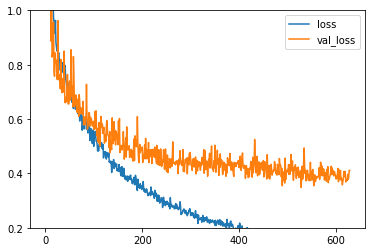

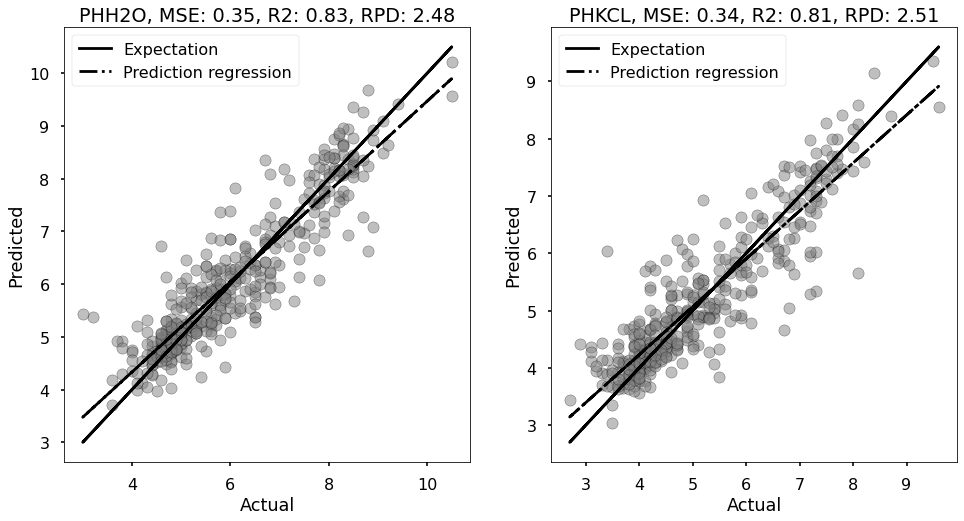

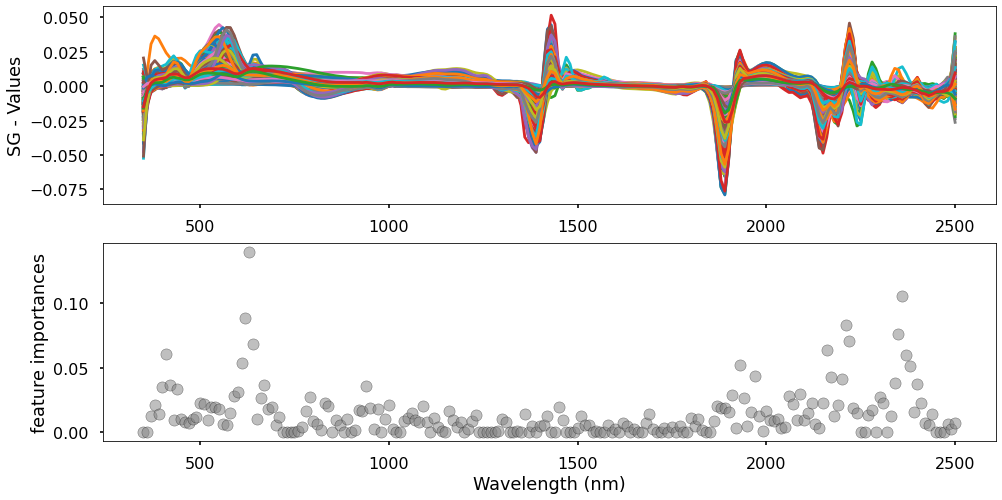

In [40]:
evaluation()

MSE: 0.3527
R2: 0.8302
RPD: 2.4802
MSE: 0.3444
R2: 0.8110
RPD: 2.5098


Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


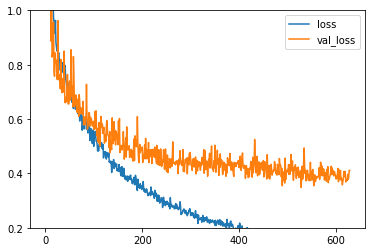

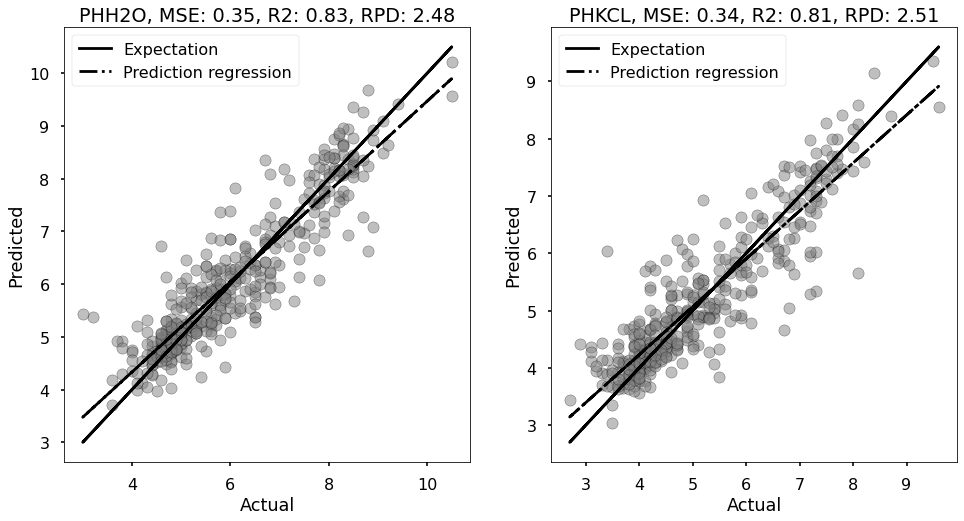

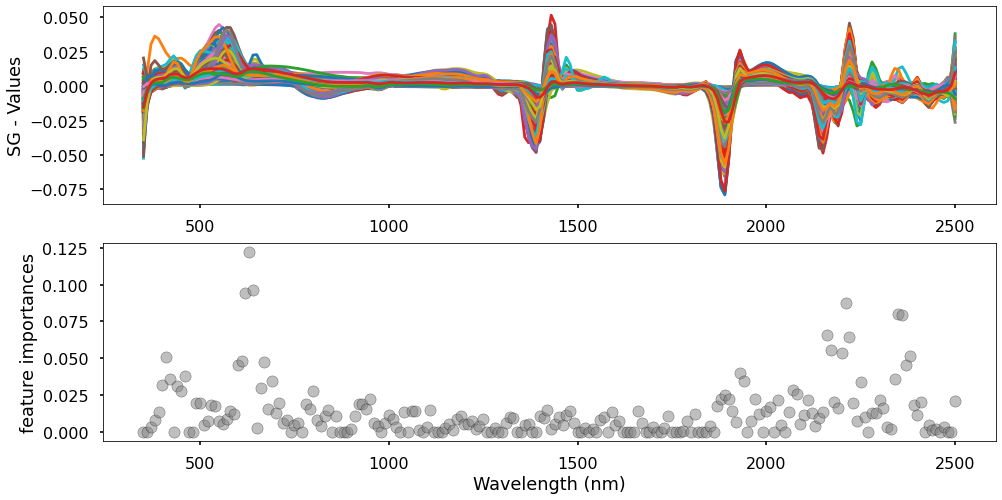

In [41]:
evaluation()